In [5]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np

In [2]:
!pip install pmdarima

  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.0
    Uninstalling statsmodels-0.12.0:
      Successfully uninstalled statsmodels-0.12.0


ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'C:\\Users\\savil\\anaconda3\\Lib\\site-packages\\~tatsmodels\\tsa\\kalmanf\\kalman_loglike.cp38-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [19]:
df = pd.read_csv("Documents/Stock.txt")
df.to_csv("Documents/Stock.csv")
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv("Documents/Stock.txt", sep = ',', index_col = 'Date', parse_dates=['Date'], 
               date_parser = dateparse).fillna(0)

In [20]:
df.head()

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
1996-04-12,1.05,1.79,1.02,1.38,408720000,0
1996-04-15,1.49,1.50,1.25,1.34,79231200,0
1996-04-16,1.34,1.34,1.17,1.20,48026400,0
1996-04-17,1.18,1.18,1.03,1.12,42871200,0
1996-04-18,1.25,1.25,1.17,1.22,27352800,0


In [21]:
df.describe()

,Open,High,Low,Close,Volume,OpenInt
count,5434.000000,5434.000000,5434.000000,5434.000000,5.434000e+03,5434.0
mean,25.401708,25.862379,24.925755,25.388213,2.321796e+07,0.0
std,17.241659,17.642258,16.848659,17.235488,2.127747e+07,0.0
min,0.660000,0.680000,0.650000,0.660000,0.000000e+00,0.0
25%,13.712500,13.990000,13.475000,13.690000,1.276903e+07,0.0
50%,23.375000,23.725000,23.000000,23.440000,1.830949e+07,0.0
75%,35.497500,36.072500,34.850000,35.470000,2.676091e+07,0.0
max,116.120000,125.030000,110.500000,118.750000,4.377436e+08,0.0


In [22]:
df.dtypes

Open       float64
High       float64
Low        float64
Close      float64
Volume       int64
OpenInt      int64
dtype: object

In [24]:
df.isnull().sum()

Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
dtype: int64

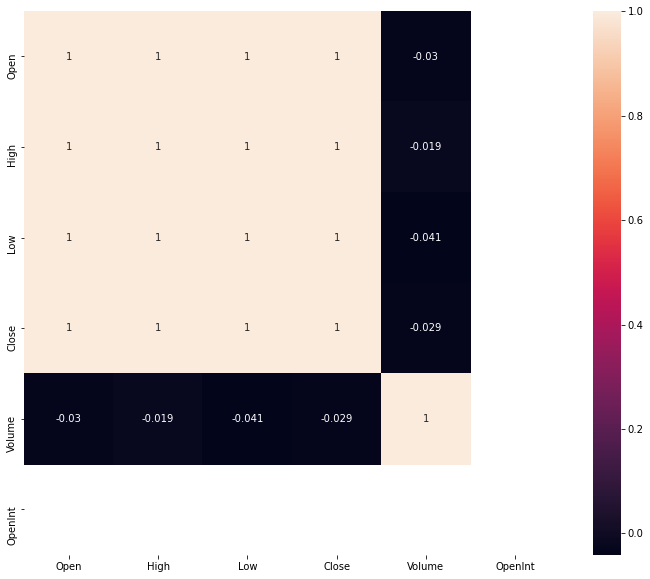

In [25]:
import seaborn as sns
plt.figure(figsize = (12,10))
sns.heatmap(df.corr(), annot = True, cbar = True)
plt.show()

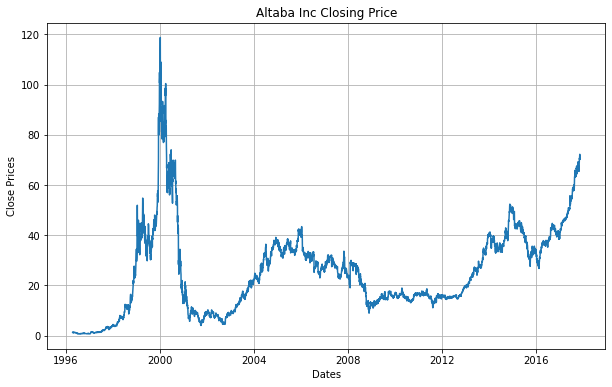

In [28]:
plt.figure(figsize = (10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(df['Close'])
plt.title("Altaba Inc Closing Price")
plt.show()

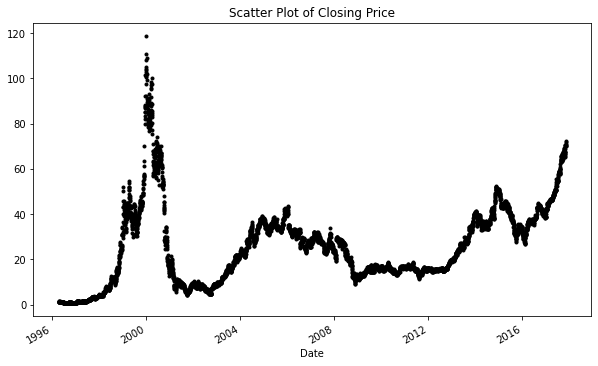

In [29]:
df_close = df['Close']
df_close.plot(style = 'k.')
plt.title("Scatter Plot of Closing Price")
plt.show()

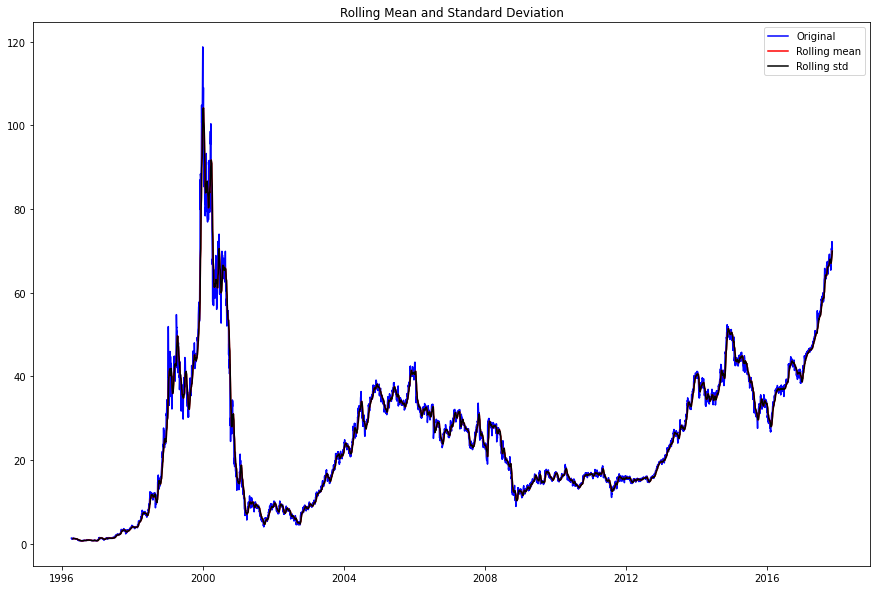

Results of dickey fuller test
Test statistics                  -2.062280
p-value                           0.259950
No. of lags used                 32.000000
Number of observations used    5401.000000
critical value (1%)              -3.431561
critical value (5%)              -2.862075
critical value (10%)             -2.567055
dtype: float64


In [33]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).mean()
    plt.figure(figsize = (15,10))
    plt.plot(timeseries, color = 'blue', label = 'Original')
    plt.plot(rolmean, color = 'red', label = 'Rolling mean')
    plt.plot(rolstd, color = 'black', label = 'Rolling std')
    plt.legend(loc = 'best')
    plt.title("Rolling Mean and Standard Deviation")
    plt.show(block = False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries, autolag = 'AIC')
    output = pd.Series(adft[0:4], index = ['Test statistics', 'p-value', 'No. of lags used', 'Number of observations used'])
    for key, values in adft[4].items():
        output['critical value (%s)' %key] = values
    print(output)

test_stationarity(df_close)

<Figure size 720x432 with 0 Axes>

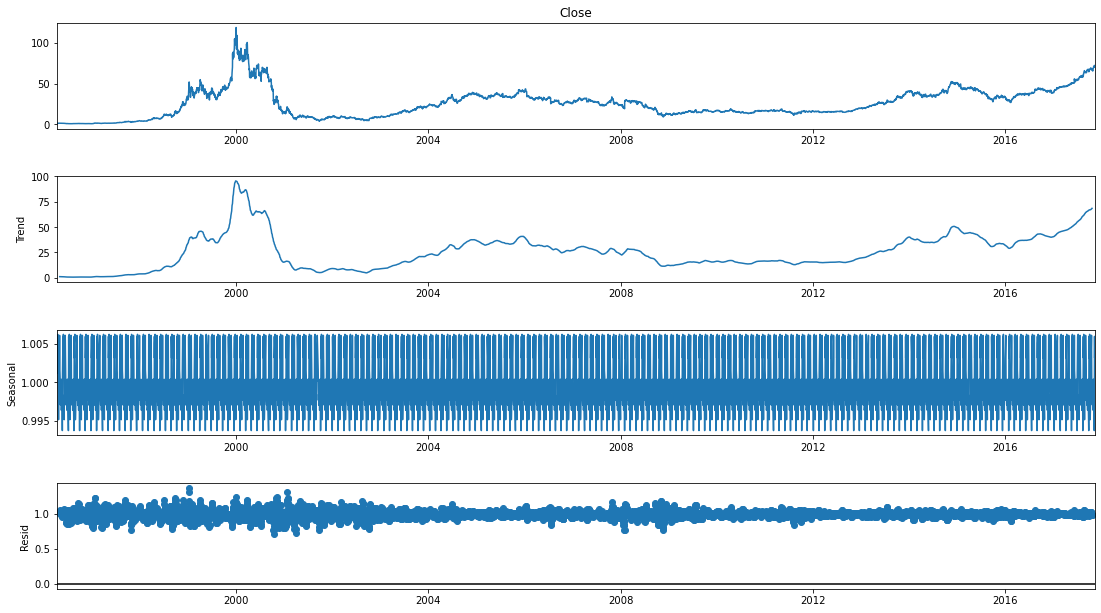

In [34]:
result = seasonal_decompose(df_close, model = 'multiplicative', freq = 30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


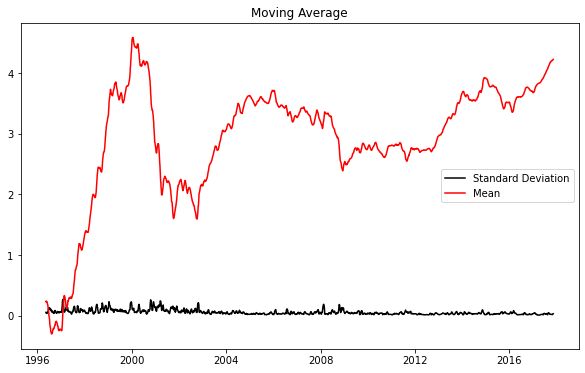

In [37]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(22).mean()
std_dev = df_log.rolling(22).std()
plt.legend(loc = 'best')
plt.title("Moving Average")
plt.plot(std_dev, color = 'black', label = 'Standard Deviation')
plt.plot(moving_avg, color = 'red', label = 'Mean')
plt.legend()
plt.show()

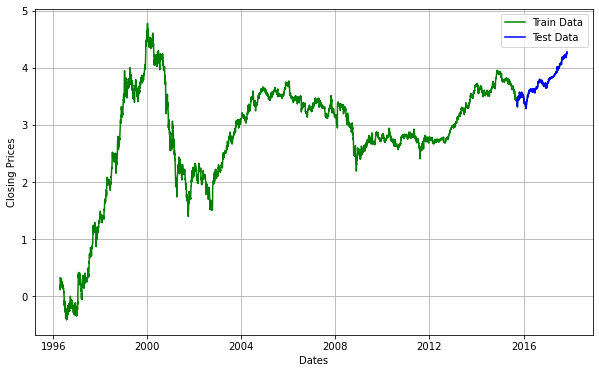

In [38]:
# Train and Test
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize = (10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label = 'Train Data')
plt.plot(test_data, 'blue', label = 'Test Data')
plt.legend()

In [39]:
model_autoARIMA = auto_arima(train_data, start_p = 0, start_q = 0,
                            test = 'adf',
                            max_p = 3,
                            m = 1,
                            d = None,
                            seasonal = False,
                            start_P = 0,
                            D = 0,
                            trace = True,
                            error_action = 'ignore',
                            suppress_warnings = True,
                            stepwise = True) 
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-18377.184, Time=0.42 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-18375.274, Time=1.37 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-18375.280, Time=0.79 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-18377.513, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-18378.090, Time=0.98 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-18386.172, Time=1.74 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-18386.124, Time=0.45 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-18384.395, Time=1.71 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-18384.593, Time=3.71 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-18386.043, Time=3.14 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-18386.390, Time=0.45 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-18386.638, Time=0.71 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-18386.295, Time=0.56 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-18384.643, Time=0.71 sec
 ARIM

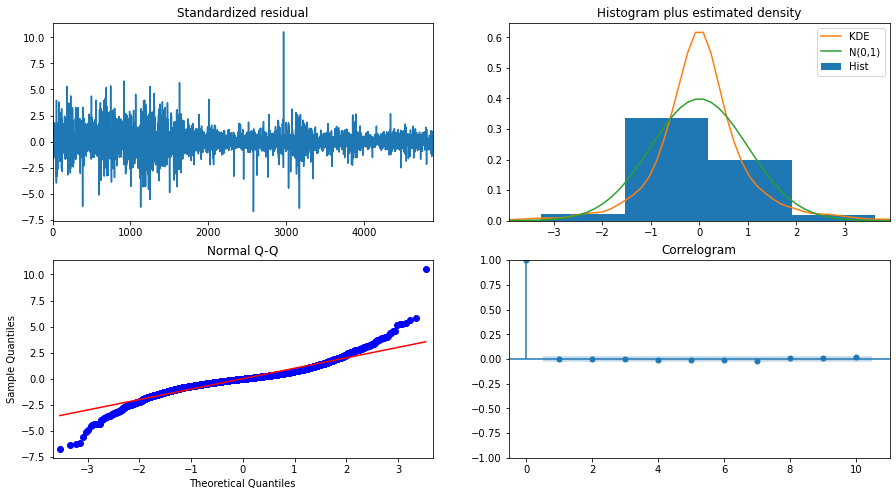

In [40]:
model_autoARIMA.plot_diagnostics(figsize = (15,8))
plt.show()

In [41]:
model = ARIMA(train_data, order = (3, 1, 2))
fitted = model.fit(disp = -1)
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4886
Model:                 ARIMA(3, 1, 2)   Log Likelihood                9204.201
Method:                       css-mle   S.D. of innovations              0.037
Date:                Mon, 01 Feb 2021   AIC                         -18394.402
Time:                        13:01:12   BIC                         -18348.943
Sample:                             1   HQIC                        -18378.450
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0007      0.001      1.292      0.196      -0.000       0.002
ar.L1.D.Close    -1.6322      0.017    -96.745      0.000      -1.665      -1.599
ar.L2.D.Close    -0.9840      0.025    -

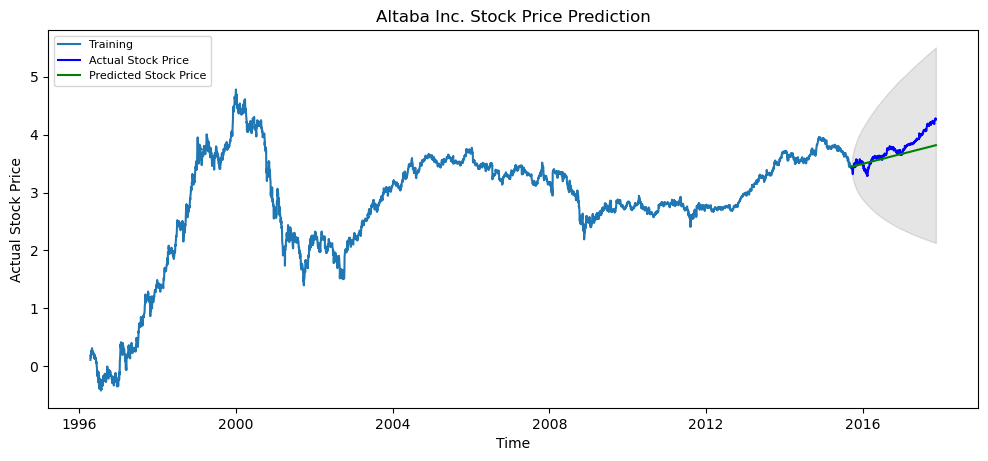

In [43]:
# Forecast Time sis
fc, se, conf = fitted.forecast(544, alpha = 0.05)
fc_series = pd.Series(fc, index = test_data.index)
lower_series = pd.Series(conf[:, 0], index = test_data.index)
upper_series = pd.Series(conf[:, 1], index = test_data.index)
plt.figure(figsize = (12, 5), dpi = 100)
plt.plot(train_data, label = 'Training')
plt.plot(test_data, color = 'blue', label = 'Actual Stock Price')
plt.plot(fc_series, color = 'green', label = 'Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, color = 'k', alpha = .10)
plt.title("Altaba Inc. Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Actual Stock Price")
plt.legend(loc = 'upper left', fontsize = 8)
plt.show()

In [44]:
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.03331311367631759
MAE: 0.13802171574301902
RMSE: 0.18251880362394882
MAPE: 0.035331214890116765
